<a href="https://colab.research.google.com/github/bcorr24/Final-Project-Data-301/blob/master/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Predicting MVP by Allstars

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')
full_data = pd.read_csv('/content/gdrive/My Drive/full_data.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


I wanted to try and predict this years mvp by using the data I have so for this part I split up the data into two sections. One training data set and then the prediction data set.

In [0]:
prediction_data = full_data[full_data["Season"] == "2019-20"]
full_data = full_data[full_data["Season"] != "2019-20"]

In [0]:
#cleaning up the data a little to work on it
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np


full_data[["games_played", "Age", "mpg",	"ppg",	"rpg",	"apg",
      "spg",	"bpg",	"FG%",	"3%",	"FT%"]] = full_data[["games_played","Age",
      "mpg",	"ppg",	"rpg",	"apg",	"spg",	"bpg",	"FG%",	"3%",	"FT%"
      ]].apply(pd.to_numeric, errors='coerce', axis=1)

#fill the missing data with the median so i can still use those data points
median_mpg = full_data['mpg'].median()
median_spg = full_data['spg'].median()
median_bpg = full_data['bpg'].median()
median_3 = full_data['3%'].median()
full_data['Position'].fillna("NA", inplace= True)
full_data['mpg'].fillna(median_mpg, inplace = True)
full_data['spg'].fillna(median_spg, inplace = True)
full_data['bpg'].fillna(median_bpg, inplace = True)
full_data['3%'].fillna(median_3, inplace = True)

First I wanted to find which variables would be best used in the model so I got the cv score for each of the different features.

In [4]:

def get_cv_score(features):
  # define pipeline
  # calculate errors from cross-validation
  ct = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), [x for x in ["Position", "Team"] if x in features]), 
    remainder="passthrough"  
  )

  pipeline = make_pipeline(
    ct,
    StandardScaler(with_mean=False),
    KNeighborsClassifier(n_neighbors=7)
  )

  cv_errs = cross_val_score(pipeline, X=full_data[features], y =full_data['MVP'], 
                            cv=10, scoring="f1_macro")

  # calculate average of the cross-validation errors
  return cv_errs.mean()

# calculate and store errors for different feature sets
errs = pd.Series()

#test out different sets of variables
for features in [["Position", "Team", "Age", "mpg",	"ppg",	"rpg",	"apg",	"spg",	"bpg",	"FG%",	"3%",	"FT%"],
                 ["Position", "Team", "Age", "mpg",	"ppg",	"rpg",	"apg",	"spg",	"bpg"],
                 ["Position", "Age", "mpg",	"ppg",	"rpg",	"apg",	"spg",	"bpg"],
                 ["Team", "Age", "mpg", "ppg",	"rpg",	"apg",	"spg",	"bpg"],
                 ["Position", "Team", "Age", "mpg",	"ppg",	"rpg",	"apg", "FG%",	"3%",	"FT%"],
                 ["Age", "mpg",	"ppg",	"rpg",	"apg", "FG%",	"3%",	"FT%"],
                 ["Age", "mpg",	"ppg",	"rpg",	"apg", "spg", "bpg"],
                 ["mpg",	"ppg"]
                 ]:
  errs[str(features)] = get_cv_score(features)

errs

['Position', 'Team', 'Age', 'mpg', 'ppg', 'rpg', 'apg', 'spg', 'bpg', 'FG%', '3%', 'FT%']    0.487623
['Position', 'Team', 'Age', 'mpg', 'ppg', 'rpg', 'apg', 'spg', 'bpg']                        0.487197
['Position', 'Age', 'mpg', 'ppg', 'rpg', 'apg', 'spg', 'bpg']                                0.497894
['Team', 'Age', 'mpg', 'ppg', 'rpg', 'apg', 'spg', 'bpg']                                    0.488756
['Position', 'Team', 'Age', 'mpg', 'ppg', 'rpg', 'apg', 'FG%', '3%', 'FT%']                  0.487620
['Age', 'mpg', 'ppg', 'rpg', 'apg', 'FG%', '3%', 'FT%']                                      0.488472
['Age', 'mpg', 'ppg', 'rpg', 'apg', 'spg', 'bpg']                                            0.487908
['mpg', 'ppg']                                                                               0.489321
dtype: float64

As you can see the third list of variables turned out to be the best set. I then used these variables to try and find the best scalar to use. This also turned out to be the same as what I was already using, a standard scaler.

In [5]:
from sklearn.preprocessing import StandardScaler, Normalizer, MaxAbsScaler, RobustScaler
def get_cv_error(features):
  # define pipeline
  # calculate errors from cross-validation
  ct = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), ["Position"]), 
    remainder="passthrough"  
  )

    
  pipeline = make_pipeline(
      ct,
      features,
      KNeighborsClassifier(n_neighbors=7)

  )

  cv_errs = cross_val_score(pipeline, X=full_data[['Position', 'Age', 'mpg', 'ppg', 'rpg', 'apg', 'spg', 'bpg']], y =full_data['MVP'], 
                            cv=10, scoring="f1_macro")
  # calculate average of the cross-validation errors
  return cv_errs.mean()

errs = pd.Series()
for features in [StandardScaler(with_mean=False), Normalizer(), MaxAbsScaler(), RobustScaler(with_centering=False)]:
  errs[str(features)] = get_cv_error(features)
errs

StandardScaler(copy=True, with_mean=False, with_std=True)                                                      0.497894
Normalizer(copy=True, norm='l2')                                                                               0.489461
MaxAbsScaler(copy=True)                                                                                        0.486747
RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=False,\n             with_scaling=True)    0.488190
dtype: float64

Finally I wanted to get the best number of nearest neighbors. It turns out that 1 was the best just because my recall is so low. 

1     0.520406
3     0.512218
7     0.497894
18    0.490019
12    0.490019
dtype: float64

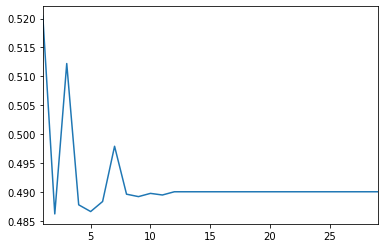

In [6]:
def get_cv_error(k):
  # define pipeline
  # calculate errors from cross-validation
  ct = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), ["Position"]), 
    remainder="passthrough"  
  )

    
  pipeline = make_pipeline(
      ct,
      StandardScaler(with_mean=False),
      KNeighborsClassifier(n_neighbors= k)
  )

  cv_errs = cross_val_score(pipeline, X=full_data[['Position', 'Age', 'mpg', 'ppg', 'rpg', 'apg', 'spg', 'bpg']], y =full_data['MVP'], 
                            cv=10, scoring="f1_macro")

  # calculate average of the cross-validation errors
  return cv_errs.mean()

ks = pd.Series(range(1, 30))
ks.index = range(1, 30)
test_errs = ks.apply(get_cv_error)

test_errs.plot.line()
test_errs.sort_values(ascending=False).head(5)

In my final model I used the previous best features that I found. I then got the prediction probabilities for each player.

In [7]:
 X_train =full_data[['Position', 'Age', 'mpg', 'ppg', 'rpg', 'apg', 'spg', 'bpg']]
 y_train =full_data['MVP']
 X_test = prediction_data[['Position', 'Age', 'mpg', 'ppg', 'rpg', 'apg', 'spg', 'bpg']]

ct = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), ["Position"]), 
    remainder="passthrough"  
  )

    
pipeline = make_pipeline(
      ct,
      StandardScaler(with_mean=False),
      #I chose to use 7 as 1 and 3 limit the prediction capabilities.
       KNeighborsClassifier(n_neighbors= 7)
  )

pipeline.fit(X_train, y_train)

pipeline.predict_proba(X_test)


array([[0.85714286, 0.14285714],
       [1.        , 0.        ],
       [0.85714286, 0.14285714],
       [0.57142857, 0.42857143],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.85714286, 0.14285714],
       [0.85714286, 0.14285714],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.85714286, 0.14285714],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.85714286, 0.14285714]])

It turns out that the model predicts James Harden the MVP. This makes alot of sense as stastically Harden is the best statistically. As seen by the stats displayed below, he scores alot and tends to "pat" the stats alot which helps him out. 

In [0]:
prediction_data.reset_index(inplace=True)

In [9]:
prediction_data.iloc[3]

index                    623
Season               2019-20
Player          James Harden
Position                  SG
Team                     HOU
Age                       30
games_played              61
mpg                     36.7
ppg                     34.4
rpg                      6.4
apg                      7.4
spg                      1.7
bpg                      0.9
FG%                    0.435
3%                     0.352
FT%                    0.861
MVP                        0
Name: 3, dtype: object

##Conclusion
In retrospect there are a couple problems that came up along the way. First was the decision to use ABA mvp's the same as NBA mvp's. This maybe skewed the data a little as there were more mvp's in the early years of the NBA rather than the later years. Another problem I ran into was that my model was getting a super low recall. This came to be because there are not alot of mvp's but there are alot of allstars so when it came to predicting mvp's I could get decent accuracy and precision because you just predict that all are not mvp's but recall was super low. My attempt to try and predict mvp's just using basic stats was not all that succesful unfortuanately but I learned alot about creating and making models, along with data collection and analysis. 

